In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import lr_scheduler
from tempfile import TemporaryDirectory

In [3]:
if torch.cuda.is_available():
    # Set the device to CUDA (GPU 0)
    device = torch.device("cuda:0")
else:
    # If no GPU is available, fall back to CPU
    device = torch.device("cpu")

In [4]:
base_path = "/home/intern/Documents/King_Hang/School/"
# os.chdir(BASE_PATH)

# path to animal classes
ANIMALS_PATH = './animals'

# Use only images in training folder
STYLE_ANIMALS_PATH = './style_animals/train/' 

In [5]:
from torchvision import transforms

data_dir = os.getcwd()
BATCH_SIZE = 4
IMAGE_SIZE = (224, 224)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a custom dataset
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return image, label

### Create dataloaders

1. Animals
2. Stylized Animals

#### 1. Animals

##### Visualize

##### Data Augmentation, create datasets, create dataloaders

In [6]:
def create_dataloaders(path: str):
    data = {"imgpath": [] , "labels": [] }

    category = os.listdir(path)
    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)

    df = pd.DataFrame(data) 

    #Convert labels to numbers
    lb = LabelEncoder()
    df['encoded_labels'] = lb.fit_transform(df['labels'])

    # Split data into train-valid-test
    train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
    valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print("----------Train-------------")
    print(train_df[["imgpath", "labels"]].head(5))
    print(train_df.shape)
    print("--------Validation----------")
    print(valid_df[["imgpath", "labels"]].head(5))
    print(valid_df.shape)
    print("----------Test--------------")
    print(test_df[["imgpath", "labels"]].head(5))
    print(test_df.shape)

    plt.figure(figsize=(8,5))
    for i, row in test_df.sample(n=4).reset_index().iterrows():
        plt.subplot(2,2,i+1)
        image_path = row['imgpath']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(row["labels"])
        plt.axis('off')
    plt.show()

    data_dir = os.getcwd()
    BATCH_SIZE = 4
    IMAGE_SIZE = (224, 224)


    # create datasets
    trainset = ImageDataset(dataframe=train_df, root_dir=data_dir, transform=transform)
    validset = ImageDataset(dataframe=valid_df, root_dir=data_dir, transform=transform)
    testset = ImageDataset(dataframe=test_df, root_dir=data_dir, transform=transform)

    # create dataloaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)

    dataset_sizes = {'train': len(train_df), 'val': len(valid_df), 'test': len(test_df)}

    return trainloader, validloader, testloader, dataset_sizes

----------Train-------------
                                imgpath       labels
0         ./animals/goat/4f21ad4aa0.jpg         goat
1   ./animals/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./animals/moth/9e81bc5555.jpg         moth
3        ./animals/shark/40f50c6990.jpg        shark
4  ./animals/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                             imgpath    labels
0     ./animals/koala/9ca7babf11.jpg     koala
1      ./animals/goat/2e7b3347db.jpg      goat
2       ./animals/pig/1d8c1f3bbd.jpg       pig
3  ./animals/seahorse/37aaf8c8d7.jpg  seahorse
4  ./animals/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                             imgpath    labels
0     ./animals/otter/7c3868b76f.jpg     otter
1    ./animals/turtle/05e2720400.jpg    turtle
2     ./animals/whale/3b4307af02.jpg     whale
3      ./animals/lion/7d8f058238.jpg      lion
4  ./animals/seahorse/2cd0c57bad.jpg  seahorse
(487, 3)


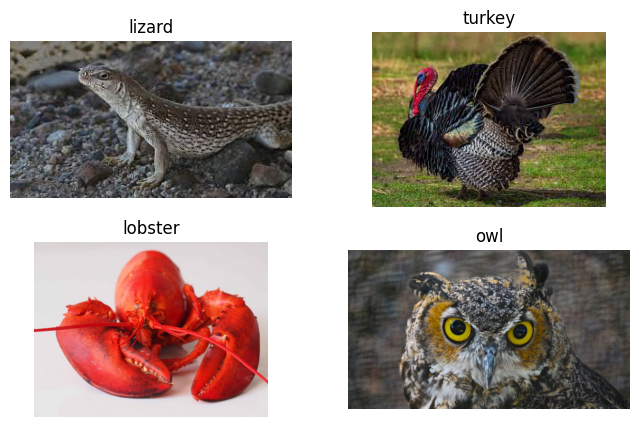

In [7]:
trainloader, validloader, testloader, dataset_sizes = create_dataloaders(ANIMALS_PATH)
dataloaders = {'train': trainloader, 'val': validloader, 'test': testloader}

##### Stylized Animals

----------Train-------------
                                            imgpath       labels
0         ./style_animals/train/goat/4f21ad4aa0.jpg         goat
1   ./style_animals/train/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./style_animals/train/moth/9e81bc5555.jpg         moth
3        ./style_animals/train/shark/40f50c6990.jpg        shark
4  ./style_animals/train/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                                         imgpath    labels
0     ./style_animals/train/koala/9ca7babf11.jpg     koala
1      ./style_animals/train/goat/2e7b3347db.jpg      goat
2       ./style_animals/train/pig/1d8c1f3bbd.jpg       pig
3  ./style_animals/train/seahorse/37aaf8c8d7.jpg  seahorse
4  ./style_animals/train/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                                         imgpath    labels
0     ./style_animals/train/otter/7c3868b76f.jpg     otter
1    ./style_animals/train/turt

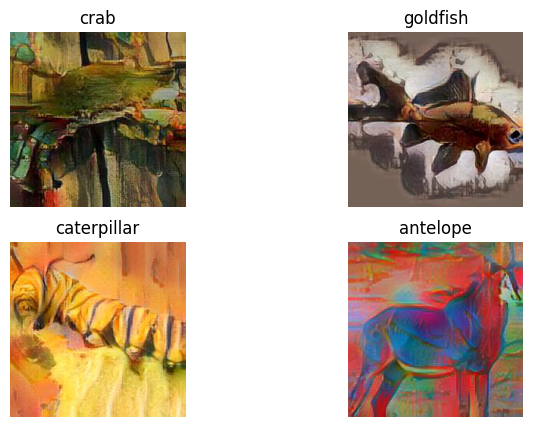

In [8]:
s_trainloader, s_validloader, s_testloader, s_dataset_sizes = create_dataloaders(STYLE_ANIMALS_PATH)
s_dataloaders = {'train': s_trainloader, 'val': s_validloader, 'test':s_testloader}

----------Train-------------
                                imgpath       labels
0         ./figures/goat/4f21ad4aa0.jpg         goat
1   ./figures/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./figures/moth/9e81bc5555.jpg         moth
3        ./figures/shark/40f50c6990.jpg        shark
4  ./figures/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                             imgpath    labels
0     ./figures/koala/9ca7babf11.jpg     koala
1      ./figures/goat/2e7b3347db.jpg      goat
2       ./figures/pig/1d8c1f3bbd.jpg       pig
3  ./figures/seahorse/37aaf8c8d7.jpg  seahorse
4  ./figures/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                             imgpath    labels
0     ./figures/otter/7c3868b76f.jpg     otter
1    ./figures/turtle/05e2720400.jpg    turtle
2     ./figures/whale/3b4307af02.jpg     whale
3      ./figures/lion/7d8f058238.jpg      lion
4  ./figures/seahorse/2cd0c57bad.jpg  seahorse
(487, 3)


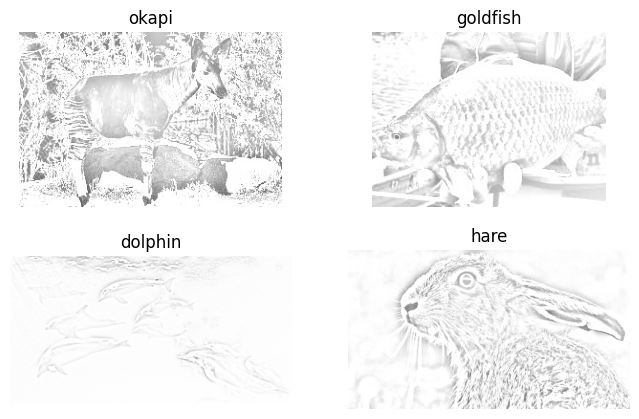

In [9]:
# Sketch animals
SKETCH_PATH = './figures/'

sh_trainloader, sh_validloader, sh_testloader, sh_dataset_sizes = create_dataloaders(SKETCH_PATH)
sh_dataloaders = {'train': sh_trainloader, 'val': sh_validloader, 'test': sh_testloader}

#### Top 5 Accuracy

Top-5 accuracy provides a more forgiving evaluation metric by considering whether the correct class is within the top 5 predicted classes. This is especially relevant in image recognition, where there can be a vast number of object categories. 

High top-5 accuracy indicates that the model is not only good at picking the most likely class but also capable of recognizing other plausible classes. 

It's especially useful when comparing models that have similar performance on the top-1 (single most likely class) accuracy but differ in their ability to provide a ranked list of possible classes.

In [10]:
def get_accuracy(model, testloader):

    model.eval()
    model = model.to(device)
    correct = 0
    total = 0
    predictions = list()

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Record predictions
            predictions.append(outputs)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return predictions

def top_5_accuracy(predictions, labels):
    _, top5_predictions = torch.topk(predictions, 5, dim=1)
    correct = top5_predictions.eq(labels.view(-1, 1).expand_as(top5_predictions))
    top5_acc = correct.sum().item() / len(labels)
    return top5_acc

##### Training code

In [11]:
import time
# From Official Pytorch page: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
            
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### What to do now?

---

#### 1. Pretrained + finetuned on animals + finetuned on stylized

#### Load model state dict

##### rES18

In [28]:
# Create instance of ResNet18 with modified output
res18 = models.resnet18()
num_ftrs = res18.fc.in_features
res18.fc = nn.Linear(num_ftrs, 90)

# Load the saved model state dictionary
checkpoint = torch.load("resnet18_weights.pth")

# Load the model weights from the state dictionary
res18.load_state_dict(checkpoint)

<All keys matched successfully>

In [34]:
res18 = res18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

res18 = train_model(res18, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.0380 Acc: 0.2789
val Loss: 2.5214 Acc: 0.4162

Epoch 1/24
----------
train Loss: 1.6180 Acc: 0.5800
val Loss: 2.3589 Acc: 0.4612

Epoch 2/24
----------
train Loss: 0.7682 Acc: 0.8214
val Loss: 2.0631 Acc: 0.5106

Epoch 3/24
----------
train Loss: 0.3499 Acc: 0.9317
val Loss: 2.0162 Acc: 0.5291

Epoch 4/24
----------
train Loss: 0.1653 Acc: 0.9751
val Loss: 1.8469 Acc: 0.5644

Epoch 5/24
----------
train Loss: 0.1150 Acc: 0.9809
val Loss: 1.8758 Acc: 0.5697

Epoch 6/24
----------
train Loss: 0.0789 Acc: 0.9894
val Loss: 1.8690 Acc: 0.5697

Epoch 7/24
----------
train Loss: 0.0614 Acc: 0.9923
val Loss: 1.7900 Acc: 0.5838

Epoch 8/24
----------
train Loss: 0.0481 Acc: 0.9952
val Loss: 1.7576 Acc: 0.6005

Epoch 9/24
----------
train Loss: 0.0484 Acc: 0.9934
val Loss: 1.7370 Acc: 0.5952

Epoch 10/24
----------
train Loss: 0.0449 Acc: 0.9952
val Loss: 1.7066 Acc: 0.6049

Epoch 11/24
----------
train Loss: 0.0480 Acc: 0.9950
val Loss: 1.7103 Acc: 0.6041

Ep

##### ResNet50:

In [12]:
# Create instance of ResNet18 with modified output
res50 = models.resnet50()
num_ftrs = res50.fc.in_features
res50.fc = nn.Linear(num_ftrs, 90)

# Load the saved model state dictionary
checkpoint = torch.load("resnet50_weights.pth")

# Load the model weights from the state dictionary
res50.load_state_dict(checkpoint)

<All keys matched successfully>

In [13]:
res50 = res50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(res50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

res50 = train_model(res50, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.1652 Acc: 0.2657
val Loss: 3.0096 Acc: 0.3545

Epoch 1/24
----------
train Loss: 2.0452 Acc: 0.4832
val Loss: 2.9753 Acc: 0.3915

Epoch 2/24
----------
train Loss: 1.3664 Acc: 0.6430
val Loss: 2.6057 Acc: 0.4665

Epoch 3/24
----------
train Loss: 0.8184 Acc: 0.7915
val Loss: 2.8355 Acc: 0.4841

Epoch 4/24
----------
train Loss: 0.4362 Acc: 0.8926
val Loss: 2.6198 Acc: 0.5123

Epoch 5/24
----------
train Loss: 0.2382 Acc: 0.9513
val Loss: 2.4327 Acc: 0.5511

Epoch 6/24
----------
train Loss: 0.1789 Acc: 0.9598
val Loss: 2.3168 Acc: 0.5467

Epoch 7/24
----------
train Loss: 0.1050 Acc: 0.9809
val Loss: 2.0876 Acc: 0.5741

Epoch 8/24
----------
train Loss: 0.0700 Acc: 0.9897
val Loss: 2.0284 Acc: 0.5829

Epoch 9/24
----------
train Loss: 0.0595 Acc: 0.9881
val Loss: 2.0062 Acc: 0.6023

Epoch 10/24
----------
train Loss: 0.0478 Acc: 0.9929
val Loss: 1.9183 Acc: 0.6067

Epoch 11/24
----------
train Loss: 0.0519 Acc: 0.9913
val Loss: 1.9725 Acc: 0.6076

Ep

In [51]:
predictions = get_accuracy(res50, testloader)

Test Accuracy: 70.84%


In [52]:
res50.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = res50(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 90.51%


Test on sketches

In [14]:
predictions = get_accuracy(res50, sh_testloader)

Test Accuracy: 32.24%


In [15]:
res50.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in sh_testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = res50(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(sh_testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 55.81%


#### 2. Pretrained + finetuned stylized

Hypothesis: performs worse because it sees fewer animal pictures

In [35]:
# Create instance of ResNet18 with modified output
res18 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = res18.fc.in_features
res18.fc = nn.Linear(num_ftrs, 90)

In [36]:
res18 = res18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

res18 = train_model(res18, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.1790 Acc: 0.0709
val Loss: 3.2812 Acc: 0.1966

Epoch 1/24
----------
train Loss: 2.8828 Acc: 0.2958
val Loss: 2.4436 Acc: 0.3836

Epoch 2/24
----------
train Loss: 1.9456 Acc: 0.5239
val Loss: 2.3988 Acc: 0.4312

Epoch 3/24
----------
train Loss: 1.2042 Acc: 0.7145
val Loss: 2.3043 Acc: 0.4577

Epoch 4/24
----------
train Loss: 0.6213 Acc: 0.8748
val Loss: 2.0509 Acc: 0.5053

Epoch 5/24
----------
train Loss: 0.3164 Acc: 0.9500
val Loss: 2.0235 Acc: 0.5229

Epoch 6/24
----------
train Loss: 0.1895 Acc: 0.9762
val Loss: 1.9909 Acc: 0.5450

Epoch 7/24
----------
train Loss: 0.1149 Acc: 0.9865
val Loss: 1.8311 Acc: 0.5829

Epoch 8/24
----------
train Loss: 0.0921 Acc: 0.9926
val Loss: 1.7952 Acc: 0.5855

Epoch 9/24
----------
train Loss: 0.0768 Acc: 0.9934
val Loss: 1.8257 Acc: 0.5750

Epoch 10/24
----------
train Loss: 0.0593 Acc: 0.9976
val Loss: 1.7765 Acc: 0.5908

Epoch 11/24
----------
train Loss: 0.0653 Acc: 0.9939
val Loss: 1.7903 Acc: 0.5952

Ep

### 3. Pretrained ON the entire SIN

Their repository offers pretrained models   
https://github.com/rgeirhos/texture-vs-shape

In [10]:
import sys

T_PATH = './texture-vs-shape/models/'

sys.path.append(T_PATH)

In [11]:
from load_pretrained_models import load_model

model_A = "resnet50_trained_on_SIN"
model_B = "resnet50_trained_on_SIN_and_IN"
model_C = "resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN"

#### Non-FINETUNED

#### Fine-tuned only 

#### Fine-tuned on ANIMALS

##### Model A

In [14]:
modelA_nostyle = load_model(model_name = model_A)

modelA_nostyle = modelA_nostyle.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(modelA_nostyle.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# animals dataset
modelA_nostyle = train_model(modelA_nostyle, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = dataloaders,
                       num_epochs=25)

Using the ResNet50 architecture.
Epoch 0/24
----------
train Loss: 3.4366 Acc: 0.2702
val Loss: 1.8627 Acc: 0.5670

Epoch 1/24
----------
train Loss: 1.3612 Acc: 0.6457
val Loss: 1.2820 Acc: 0.7125

Epoch 2/24
----------
train Loss: 0.5909 Acc: 0.8505
val Loss: 1.0850 Acc: 0.7619

Epoch 3/24
----------
train Loss: 0.2932 Acc: 0.9346
val Loss: 0.9913 Acc: 0.7840

Epoch 4/24
----------
train Loss: 0.1932 Acc: 0.9608
val Loss: 0.8955 Acc: 0.7945

Epoch 5/24
----------
train Loss: 0.1217 Acc: 0.9775
val Loss: 0.8945 Acc: 0.8166

Epoch 6/24
----------
train Loss: 0.0838 Acc: 0.9852
val Loss: 0.8131 Acc: 0.8307

Epoch 7/24
----------
train Loss: 0.0651 Acc: 0.9899
val Loss: 0.7408 Acc: 0.8316

Epoch 8/24
----------
train Loss: 0.0547 Acc: 0.9923
val Loss: 0.7251 Acc: 0.8404

Epoch 9/24
----------
train Loss: 0.0513 Acc: 0.9899
val Loss: 0.6990 Acc: 0.8351

Epoch 10/24
----------
train Loss: 0.0450 Acc: 0.9934
val Loss: 0.6934 Acc: 0.8466

Epoch 11/24
----------
train Loss: 0.0555 Acc: 0.9907

In [15]:
predictions = get_accuracy(modelA_nostyle, testloader)

Test Accuracy: 84.19%


In [16]:
modelA_nostyle.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelA_nostyle(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 96.24%


Test on Sketch dataset

In [28]:
predictions = get_accuracy(modelA_nostyle, sh_testloader)

Test Accuracy: 32.24%


In [29]:
modelA_nostyle.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in sh_testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelA_nostyle(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(sh_testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 59.49%


##### Model B

In [17]:
modelB_nostyle = load_model(model_name = model_B)

modelB_nostyle = modelB_nostyle.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(modelB_nostyle.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# animals dataset
modelB_nostyle = train_model(modelB_nostyle, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = dataloaders,
                       num_epochs=25)

Using the ResNet50 architecture.


/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 3.2342 Acc: 0.3197
val Loss: 1.4559 Acc: 0.6429

Epoch 1/24
----------
train Loss: 1.1751 Acc: 0.6989
val Loss: 0.9917 Acc: 0.7690

Epoch 2/24
----------
train Loss: 0.5990 Acc: 0.8563
val Loss: 1.0560 Acc: 0.7672

Epoch 3/24
----------
train Loss: 0.2996 Acc: 0.9331
val Loss: 0.7809 Acc: 0.8219

Epoch 4/24
----------
train Loss: 0.1632 Acc: 0.9688
val Loss: 0.6878 Acc: 0.8448

Epoch 5/24
----------
train Loss: 0.1129 Acc: 0.9788
val Loss: 0.7330 Acc: 0.8333

Epoch 6/24
----------
train Loss: 0.0935 Acc: 0.9833
val Loss: 0.7307 Acc: 0.8439

Epoch 7/24
----------
train Loss: 0.0810 Acc: 0.9878
val Loss: 0.7233 Acc: 0.8457

Epoch 8/24
----------
train Loss: 0.0582 Acc: 0.9899
val Loss: 0.6460 Acc: 0.8483

Epoch 9/24
----------
train Loss: 0.0540 Acc: 0.9905
val Loss: 0.6964 Acc: 0.8492

Epoch 10/24
----------
train Loss: 0.0490 Acc: 0.9915
val Loss: 0.6745 Acc: 0.8466

Epoch 11/24
----------
train Loss: 0.0489 Acc: 0.9905
val Loss: 0.6621 Acc: 0.8563

Ep

In [18]:
predictions = get_accuracy(modelB_nostyle, testloader)

Test Accuracy: 87.68%


In [20]:
modelB_nostyle.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelB_nostyle(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 96.86%


Test on Sketch dataset

In [30]:
predictions = get_accuracy(modelB_nostyle, sh_testloader)

Test Accuracy: 39.43%


In [32]:
modelB_nostyle.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in sh_testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelB_nostyle(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(sh_testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 66.05%


##### Model C

In [21]:
modelC_nostyle = load_model(model_name = model_C)

modelC_nostyle = modelC_nostyle.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(modelC_nostyle.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# animals dataset
modelC_nostyle = train_model(modelC_nostyle, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = dataloaders,
                       num_epochs=25)

Using the ResNet50 architecture.


/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar" to /home/intern/.cache/torch/hub/checkpoints/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar
100%|██████████| 195M/195M [00:09<00:00, 21.3M

Epoch 0/24
----------
train Loss: 3.5247 Acc: 0.2466
val Loss: 1.8744 Acc: 0.5467

Epoch 1/24
----------
train Loss: 1.5030 Acc: 0.6044
val Loss: 1.5073 Acc: 0.6764

Epoch 2/24
----------
train Loss: 0.8017 Acc: 0.7907
val Loss: 1.2422 Acc: 0.7213

Epoch 3/24
----------
train Loss: 0.4435 Acc: 0.8947
val Loss: 1.0046 Acc: 0.7981

Epoch 4/24
----------
train Loss: 0.2630 Acc: 0.9434
val Loss: 0.8522 Acc: 0.8166

Epoch 5/24
----------
train Loss: 0.1658 Acc: 0.9632
val Loss: 0.8269 Acc: 0.8201

Epoch 6/24
----------
train Loss: 0.1409 Acc: 0.9720
val Loss: 0.8869 Acc: 0.8183

Epoch 7/24
----------
train Loss: 0.0918 Acc: 0.9841
val Loss: 0.7040 Acc: 0.8457

Epoch 8/24
----------
train Loss: 0.0731 Acc: 0.9876
val Loss: 0.7034 Acc: 0.8422

Epoch 9/24
----------
train Loss: 0.0584 Acc: 0.9897
val Loss: 0.6805 Acc: 0.8536

Epoch 10/24
----------
train Loss: 0.0596 Acc: 0.9892
val Loss: 0.6808 Acc: 0.8545

Epoch 11/24
----------
train Loss: 0.0563 Acc: 0.9899
val Loss: 0.6524 Acc: 0.8624

Ep

In [22]:
predictions = get_accuracy(modelC_nostyle, testloader)

Test Accuracy: 86.65%


In [23]:
modelC_nostyle.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelC_nostyle(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 97.88%


Test on Sketch dataset

In [33]:
predictions = get_accuracy(modelC_nostyle, sh_testloader)

Test Accuracy: 30.18%


In [34]:
modelC_nostyle.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in sh_testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelC_nostyle(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(sh_testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 56.90%


#### **Fine-tuned on STYLE ANIMALS**

##### Model A

In [24]:
model = load_model(model_name = model_A)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Using the ResNet50 architecture.


/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 4.0826 Acc: 0.1522
val Loss: 2.6343 Acc: 0.3616

Epoch 1/24
----------
train Loss: 2.1011 Acc: 0.4782
val Loss: 2.2470 Acc: 0.5026

Epoch 2/24
----------
train Loss: 1.2005 Acc: 0.7015
val Loss: 2.0969 Acc: 0.5450

Epoch 3/24
----------
train Loss: 0.6464 Acc: 0.8420
val Loss: 1.8790 Acc: 0.6023

Epoch 4/24
----------
train Loss: 0.3138 Acc: 0.9309
val Loss: 1.7488 Acc: 0.6279

Epoch 5/24
----------
train Loss: 0.1713 Acc: 0.9672
val Loss: 1.6710 Acc: 0.6526

Epoch 6/24
----------
train Loss: 0.1391 Acc: 0.9772
val Loss: 1.6282 Acc: 0.6552

Epoch 7/24
----------
train Loss: 0.0895 Acc: 0.9870
val Loss: 1.5527 Acc: 0.6772

Epoch 8/24
----------
train Loss: 0.0781 Acc: 0.9854
val Loss: 1.4676 Acc: 0.6852

Epoch 9/24
----------
train Loss: 0.0766 Acc: 0.9884
val Loss: 1.4853 Acc: 0.6737

Epoch 10/24
----------
train Loss: 0.0468 Acc: 0.9931
val Loss: 1.4173 Acc: 0.6896

Epoch 11/24
----------
train Loss: 0.0492 Acc: 0.9934
val Loss: 1.4230 Acc: 0.6914

Ep

In [25]:
model.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 86.89%


In [26]:
predictions = get_accuracy(model, testloader)

Test Accuracy: 63.45%


Test on Sketch dataset

In [35]:
predictions = get_accuracy(model, sh_testloader)

Test Accuracy: 32.65%


In [36]:
model.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in sh_testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(sh_testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 56.42%


##### Model B

In [38]:
modelB = load_model(model_name = model_B) # or model_B or model_C

modelB = modelB.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(modelB.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
modelB = train_model(modelB, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Using the ResNet50 architecture.


/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 4.5897 Acc: 0.0836
val Loss: 3.1403 Acc: 0.2672

Epoch 1/24
----------
train Loss: 2.7483 Acc: 0.3287
val Loss: 2.7633 Acc: 0.3924

Epoch 2/24
----------
train Loss: 1.7269 Acc: 0.5613
val Loss: 2.3174 Acc: 0.4762

Epoch 3/24
----------
train Loss: 0.9977 Acc: 0.7531
val Loss: 2.2319 Acc: 0.5185

Epoch 4/24
----------
train Loss: 0.5367 Acc: 0.8746
val Loss: 1.9479 Acc: 0.5873

Epoch 5/24
----------
train Loss: 0.3034 Acc: 0.9381
val Loss: 1.8051 Acc: 0.6243

Epoch 6/24
----------
train Loss: 0.1753 Acc: 0.9677
val Loss: 1.7320 Acc: 0.6340

Epoch 7/24
----------
train Loss: 0.1076 Acc: 0.9817
val Loss: 1.5505 Acc: 0.6596

Epoch 8/24
----------
train Loss: 0.0816 Acc: 0.9884
val Loss: 1.5216 Acc: 0.6772

Epoch 9/24
----------
train Loss: 0.0674 Acc: 0.9907
val Loss: 1.4895 Acc: 0.6799

Epoch 10/24
----------
train Loss: 0.0607 Acc: 0.9929
val Loss: 1.4602 Acc: 0.6755

Epoch 11/24
----------
train Loss: 0.0665 Acc: 0.9902
val Loss: 1.5164 Acc: 0.6772

Ep

In [39]:
modelB.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelB(inputs)
        inputs = inputs.to(device)  
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 89.69%


In [40]:
predictions = get_accuracy(modelB, testloader)

Test Accuracy: 64.27%


Test on Sketch dataset

In [41]:
predictions = get_accuracy(modelB, sh_testloader)

Test Accuracy: 35.11%


In [42]:
modelB.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in sh_testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelB(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(sh_testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 59.90%


##### Model C:

In [44]:
modelC = load_model(model_name = model_C) # or model_B or model_C

modelC = modelC.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(modelC.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

modelC = train_model(modelC, criterion, optimizer_ft, exp_lr_scheduler, dataloaders = s_dataloaders,
                       num_epochs=25)

Using the ResNet50 architecture.
Epoch 0/24
----------
train Loss: 5.0077 Acc: 0.0138
val Loss: 4.5877 Acc: 0.0247

Epoch 1/24
----------
train Loss: 4.4219 Acc: 0.0384
val Loss: 4.1594 Acc: 0.0794

Epoch 2/24
----------
train Loss: 3.8964 Acc: 0.1103
val Loss: 3.6703 Acc: 0.1799

Epoch 3/24
----------
train Loss: 3.2099 Acc: 0.2284
val Loss: 3.3845 Acc: 0.2698

Epoch 4/24
----------
train Loss: 2.4343 Acc: 0.3895
val Loss: 3.1466 Acc: 0.3474

Epoch 5/24
----------
train Loss: 1.7045 Acc: 0.5613
val Loss: 3.1875 Acc: 0.3783

Epoch 6/24
----------
train Loss: 1.1048 Acc: 0.7214
val Loss: 3.1459 Acc: 0.4056

Epoch 7/24
----------
train Loss: 0.4703 Acc: 0.9018
val Loss: 2.5283 Acc: 0.4780

Epoch 8/24
----------
train Loss: 0.2751 Acc: 0.9558
val Loss: 2.4140 Acc: 0.5000

Epoch 9/24
----------
train Loss: 0.2135 Acc: 0.9688
val Loss: 2.3136 Acc: 0.5044

Epoch 10/24
----------
train Loss: 0.1754 Acc: 0.9780
val Loss: 2.3333 Acc: 0.5168

Epoch 11/24
----------
train Loss: 0.1470 Acc: 0.9847

In [45]:
modelC.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelC(inputs)
        inputs = inputs.to(device)  
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 80.46%


In [46]:
predictions = get_accuracy(modelC, testloader)

Test Accuracy: 53.80%


Sketches

In [47]:
predictions = get_accuracy(modelC, sh_testloader)

Test Accuracy: 24.02%


In [48]:
modelC.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in sh_testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelC(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(sh_testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 47.81%
